# Predict the Survival Chances of Glioma Patients 

## Introduction

A glioma is a type of tumor that starts in the glial cells of the brain or the spine. Glioma cases comprise about 30 percent of all brain and central nervous system tumours, and 80 percent of all malignant brain tumours. [[1]](#[1]) Since it is such a common type of brain tumor, it is important to predict the chances of survival of a patient in order to plan further treatment strategies at the time of diagnosis. Most patients are diagnosed based on Computed Tomography (CT) or Magnetic Resonance Imaging (MRI) scans. In this project, we use a Convolutional Neural Network (CNN) model to analyze these scans and predict whether the patient will survive.

## Related Work

During our initial research, we came across a few papers of interest which employed deep learning techniques to analyze medical imaging. A couple of them are listed briefly below:
- Use of Artificial Neural Netowrks (ANN) to predict survival of patients who were diagnosed with Amyotrophic Lateral Sclerosis (ALS) based on MRI scans. [[2]](#[2]) 
- Evaluation of deep learning networks for predicting clinical outcomes through analyzing time series CT images of patients with locally advanced non–small cell lung cancer (NSCLC). [[3]](#[3])
- Brain Tumor Segmentation and Survival Prediction Using Multimodal MRI Scans With Deep Learning [[4]](#[4])

## Content

The following topics are covered in the project:
1. [Importing the necessary modules](#Import-Modules)
2. [Data Collection](#Data-Collection)
    1. [Get all the collections from the TCIA API](#Get-all-the-collections-from-the-TCIA-API)
    2. [Map the Body part values affected by the collections name](#Map-the-Body-part-values-affected-by-the-collections-name)
    3. [Get the collections with only brain images](#Get-the-collections-with-only-brain-images)
    4. [Get the collections with clinical data and download the clinical data zip file](#Get-the-collections-with-clinical-data-and-download-the-clinical-data-zip-file)
    5. [From the clinical data, get the dataframes with vital status](#From-the-clinical-data,-get-the-dataframes-with-vital-status)
    6. [Get the patient ids and their outcomes](#Get-the-patient-ids-and-their-outcomes)
    7. [From the patient IDs and collections, get the series id](#From-the-patient-IDs-and-collections,-get-the-series-id)
    8. [From the series ids, get the first ten images in that series file](#From-the-series-ids,-get-the-first-ten-images-in-that-series-file)
3. [Data Preprocessing](#Data-Preprocessing)
4. [CNN Model](#CNN-Model)
5. [Conclusions](#Conclusions)
6. [Future Work](#Future-Work)
7. [References](#References)

## Import Modules

*The following modules were used atleast once in our course and it has been assumed that the reader knows how to download them:*
- requests
- json
- zipfile
- pandas
- tqdm
- multiprocessing
- matplotlib
- torch & torhcvision
- beautifulsoup (bs4)

*The following modules are used for carrying out specialized function related to this project:* 
- pydicom download and usage information: https://pydicom.github.io/pydicom/stable/getting_started.html
- skimage download and usage information: https://scikit-image.org/docs/dev/install.html

In [1]:
import requests
import time
import json
import zipfile
import pandas as pd
import io
import numpy as np
from itertools import cycle
import pydicom
import tqdm
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO
import multiprocessing as mp
from bs4 import BeautifulSoup
import torch
import torchvision
from torch import nn
from skimage.transform import resize
from torch.nn import Linear, ReLU, BCELoss, Conv2d, Module, Sigmoid
from torch.optim import Adam

import matplotlib.pyplot as plt
%matplotlib inline

## Data Collection

Our entire dataset was collected from the TCIA API. 

From TCIA website: **The Cancer Imaging Archive (TCIA) is a service which de-identifies and hosts a large archive of medical images of cancer accessible for public download.**[[5]](#[5])

The data are organized as “collections”; typically patients’ imaging related by a common disease (e.g. lung cancer), image modality or type (MRI, CT, digital histopathology, etc) or research focus. DICOM is the primary file format used by TCIA for radiology imaging. Supporting data related to the images such as patient outcomes, treatment details, genomics and expert analyses are also provided when available.

At first, we gathered the names of all the available collections in the API. The following function does that.

### Get all the collections from the TCIA API 

In [2]:
def getCollections():
    '''Provides all the collections available in the Archive'''
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getCollectionValues?'
    queryParams = ''
    form = 'format=json'
    url = baseurl+queryEndpoint+queryParams+form
    
    response = requests.get(url)
    if response.status_code==200:
        Collections = []
        for dictionary in response.json():
            Collections.append(dictionary['Collection'])
        return Collections
    else:
        raise ValueError('Bad/No response')

AllCollections = getCollections()

The we map each collection to its corresponding body part(s). We used the multiprocessing module to speed up our code by running it on multiple processors. The wall time required for this code to run without mutiprocessing was 10 mins 59 seconds while with multiprocessing on an 8 core CPU, it took only 2 mins 48 seconds to run.   

### Map the Body part values affected by the collections name

In [ ]:
'''DON'T RUN'''
import gbp #the function stored as a .py file

pool = mp.Pool(mp.cpu_count())
results = pool.map(gbp.getBodyPart,[c for c in AllCollections])

In [ ]:
'''DON'T RUN'''
pooledBodyPartAffected = dict(zip(AllCollections,results))
BodyPartAffected = pooledBodyPartAffected
%store BodyPartAffected

In [3]:
%store -r BodyPartAffected

We stored the mapped results as a dictionary in disk using the store magic function available in python[[6]](#[6]). This helped us to call the variables without running the above code multiple times. 

The objective of mapping each collection to the affected body part was to isolate the collections which had brain tumor patient information from other collections. 
### Get the collections with only brain images 

In [4]:
def filter_collections():
    '''returns only those collections where the body part affected is
    either the brain or the lung'''
    Collections_brain = []
    for key,value in BodyPartAffected.items():
        if len(value)==1:
            if value[0] == 'BRAIN':
                Collections_brain.append(key)
    return Collections_brain

brain = filter_collections()

Out of the collections with brain images, we found only those collections which had clinical data information of patients. Clinical Data contained the outcome of the patient which we will use as our labels later while training the model. The clinical data is obtained as a zipped file. We cannot obtain the clinical data directly using the API. Therefore, we parsed the webpage using BeautifulSoup to collect it and downloaded the zipped files. We have only looked at one collection because of computational constraints. But the method can easily be scaled up to all the collections that are available in the TCIA archive.

### Get the collections with clinical data and download the clinical data zip file

In [5]:
brain_list_clinical = []
id_wanted = 'TCGA-LGG'

for bid in brain:
    head = "https://wiki.cancerimagingarchive.net"
    page = requests.get(f"{head}/display/Public/{bid}")
    soup = BeautifulSoup(page.content, 'html.parser')
    trs = soup.findAll('tr')
    try:
        clinical_tr = [tr for tr in trs if 'Clinical' in tr.text][0]
        clinical_data_url = head+clinical_tr.a['href']
    except:
        print(f"No clinical data in collection {bid}")
        continue
    
    brain_list_clinical.append(bid)
    
    if bid == id_wanted:
        data = requests.get(clinical_data_url)
        open(f"{bid}_clinical.zip", 'wb').write(data.content)

No clinical data in collection RIDER NEURO MRI
No clinical data in collection QIN-BRAIN-DSC-MRI
No clinical data in collection LGG-1p19qDeletion
No clinical data in collection Brain-Tumor-Progression


The following are the collections that have clinical data:

In [6]:
brain_list_clinical

['TCGA-GBM', 'REMBRANDT', 'TCGA-LGG', 'ACRIN-FMISO-Brain']

We downloaded the clinical data as a zipfile and used pandas to store that information as a dataframe. Next, we selected only those patients who have survival information. 

### From the clinical data, get the dataframes with vital status

**Here, we have randomly chosen to work with the TCGA-LGG collection** 

In [7]:
zfile = 'TCGA-LGG Clinical Data 1516.zip'
def getdfs(file):
    with zipfile.ZipFile(file) as thezip:
        dataframes = []
        for filename in thezip.namelist():
            data = pd.read_csv(thezip.open(filename),sep= '\t',header=[0,1,2])
            dataframes.append(data)
        dataframes_valid = []
    for i,j in enumerate(dataframes):
        for column in j.columns:
            if 'vital_status' in column:
                dataframes_valid.append(j)
    return dataframes_valid

dfs = getdfs(zfile)

From the dataframes, we obtained the patient identification numbers along with their outcomes. The outcomes were obtained form the *vital_status* column in the dataframe. We will use the outcomes as labels for our model and the patient IDs to query for images which we will use as inputs to our model. 

### Get the patient ids and their outcomes

In [8]:
def getPatientID(df):
    PIDS = []
    for pid in df['bcr_patient_barcode'].values:
        PIDS.append(pid[0])
    labels = []
    for label in df.loc[:,'vital_status'].values:
        labels.append(label[0])
    return PIDS,labels

PID,labels = getPatientID(dfs[0])

Each patient ID has multiple series IDs that contains CT/MRI scanned images of the patients. These series IDs are required to query the images from the API.

We used multiprocessing to speed up our code and stored the variable using store magic method as above.

### From the patient IDs and collections, get the series id

In [ ]:
'''DON'T RUN'''
import gSID #the function in .py file

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(gSID.getSeriesID,[(pid,brain[3]) for pid in PID])

In [ ]:
'''DON'T RUN'''
pooledpdict = {}

for pid,label,sid in zip(PID,labels,results):
    pooledpdict[pid] = {'label':label,'SerialIDs':sid}

%store pooledpdict

In [9]:
%store -r pooledpdict

In [10]:
pdict = pooledpdict

Once we have the series IDs, we can query for the images of that patient. We stored only the first ten images from the API. Without multiprocessing, this function takes more than 8 hours to run (might also run out of memory eventually) but with multiprocessing, on an 8 core CPU, it took only 1 hour 16 minutes and 3 seconds. We also tried running it in Microsoft Azure cloud computing service but the virtual machine that we created gave a memory error. A really expensive VM  would be required to run our code on Azure, and we did not have the budget and/or resources for that.

### From the series ids, get the first ten images in that series file

In [ ]:
'''DON'T RUN'''

import gI #the function in .py file

results = pool.map(gI.getImages,[pdict[pid]['SerialIDs'] for pid in PID])
pool.close() 

The images are in DICOM format and we parsed those images using the pydicom module.  

In [ ]:
'''DON'T RUN'''

for pid,imgdata in zip(PID,results):
    imagedataset = []
    for f in imgdata:
        try:
            img = dcmread(DicomBytesIO(f))
            imagedataset.append(img.pixel_array)
        except:
            continue
        
    pdict[pid]['images'] = imagedataset 
    pdict[pid]['image_count'] = len(imagedataset)
    
%store pdict

In [11]:
%store -r pdict

## Data Preprocessing

We stored the patient data as a dictionary called *pdict*. The keys of the dictionary corresponds to the patient IDs. Each key points to another dictionary which has the following keys:
1. *label*: This contains the outcome of the patient
2. *SerialIDs*: This key is used to query images from the API
3. *images*: This has the images of the patient stored as a pixel array
4. *image_count*: The number of stored images for each patient

The dictionary was parsed as a pandas dataframe. We made two different dataframes one for training the model and the other to test it. 

In [12]:
def preprocessing(pdict):
    #forming a dataframe
    df = pd.DataFrame(pdict).T 
    
    #forming a dataframe by mapping each image of a patient to its label and patient id
    def func(idx):
        return list(zip(cycle([idx]),df.loc[idx,'images'],cycle([df.loc[idx,'label']])))
    
    df_all = list(map(func,df.index))
    spreadlist = sum(df_all,[])
    new_df = pd.DataFrame(spreadlist,columns=['PatientID','Image','label'])
    
    #splitting that new dataframe into train and test
    total = len(new_df)
    total_idx = np.random.permutation(total)
    test = int(np.ceil(0.2*total))
    test_idx = total_idx[:test]
    train_idx = total_idx[test:]
    
    dftrain = new_df.iloc[train_idx]
    dftest = new_df.iloc[test_idx]
    
    return dftrain,dftest 

dftr,dfte = preprocessing(pdict)

Then we stored the dataframes as pickle files [[9]](#[9]). 

In [ ]:
'''DON'T RUN'''
file_name = "train_csv.pkl"
dftr.to_pickle(file_name)

file_name_test = "test_data.pkl"
dfte.to_pickle(file_name_test)

Next, we visualized the data to gain more insight about the dataset and found three types of images which we defined as follows:

1. Black images: Those images without any information
2. RGB scale images: Those images that are not in grayscale format
3. Normal images: The images in grayscale format that we can use to train the model 

Two images from each of the above category is shown below:

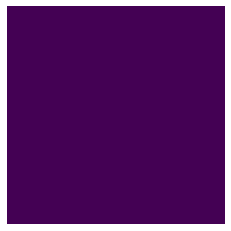

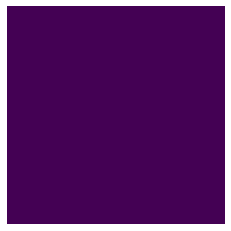

In [13]:
#print black images
count = 1
for i,image in enumerate(dftr['Image']):
    if np.max(image)==0:
        if count<3:
            plt.figure()
            plt.imshow(image)
            plt.axis('off')
        count += 1

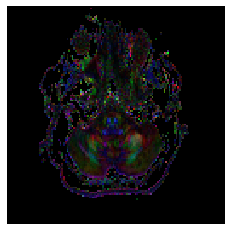

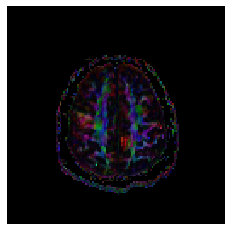

In [14]:
#print rgb images
count = 1
for i,image in enumerate(dftr['Image']):
    if len(image.shape)>2:
        if count<3:
            plt.figure()
            plt.imshow(image)
            plt.axis('off')
        count +=1 

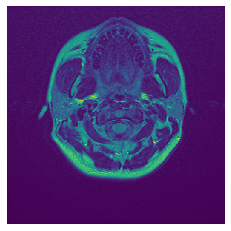

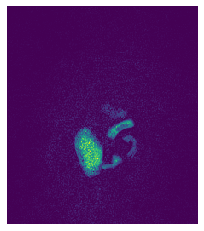

In [15]:
# print normal scanned images
count = 1
for i,image in enumerate(dftr['Image']):
    if len(image.shape)<=2 and np.max(image)!=0:
        if count<3:
            plt.figure()
            plt.imshow(image)
            plt.axis('off')
        count +=1 

We only worked with the normal images, as they contained all the information we needed. We resized each image to 60\*60 size and got rid of black or rgb images using our *process* function shown below. We created a new dataframe with 3 columns:
1. *patient id*
2. *Image*
3. *label*

In [16]:
def process(df):
    
    #get rid of black images
    df.drop(df[df['Image'].map(np.max) == 0].index,inplace=True)
    
    #get rid of rgb images
    def func(img):
        if len(img.shape)>2:
            return True
        return False
    
    df.drop(df[df['Image'].map(func)].index,inplace=True)
    
    
    #process all the available images; to grayscale,60*60,normalize,proper dimension for pytorch 
    def processImage(px_data):
        
        px_data_scaled = px_data / px_data.max()
        px_data_scaled = resize(px_data, (60, 60), anti_aliasing=True)
        px_data_scaled = px_data_scaled[None,:,:]
        return px_data_scaled    
    
    
    df.loc[:,'Image']=df.apply(lambda x: processImage(x['Image']), axis=1)
    
    #make the labels into bool Alive is True
    df.loc[:,'label'] = df['label'].map(lambda x: x == 'Alive')
    
    return df

## CNN Model

We used pytorch[[7]](#[7]) to train our model. The methods below are similar to HW-5 (deep learning assignment). We ran our code on an NVIDIA GPU to speed up the execution.  

In [17]:
class Dataset(torch.utils.data.Dataset):
    """Pet images dataset."""
    
    @staticmethod
    def from_dataframe(df):

        data = torch.as_tensor(np.array(df['Image'].tolist(),dtype=np.float32))
        labels = np.array(df['label'],dtype=np.int8)[:,None]

        
        return Dataset(data, labels)

    
    def __init__(self, data, labels):

        self.data = data
        self.labels = labels

    def __len__(self):

        return self.data.shape[0]


    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return {'label':self.labels[idx],'image':self.data[idx]}
    
def Dataset_load(df):
    return Dataset.from_dataframe(df)

In [18]:
def split(dataset):

    total = len(dataset)
    test = int(np.ceil(0.2*total))
    train = total-test

    
    return torch.utils.data.random_split(dataset,[train,test])

The CNN model architecture is as follows:

1. An input layer with 1 channel and 60\*60 size 
2. A convolutional 2D layer with RELU activation, 12 out channels and a kernel size of 5\*5
3. An average pool layer with a kernel size of 2\*2 and stride of 2
4. A second convolutional 2D layer with tanh activation, 12 out channels and a kernel size of 5\*5
5. Another average pool layer with a kernel size of 2\*2 and stride of 2
6. A linear fully connected layer with sigmoid activation

The inspiration behind this architecture is the LeNet-5 architecture developed by LeCun et al.[[8]](#[8])


In [19]:
class Model(nn.Module):
    def __init__(self,num_layers,kernelsize):
        '''num_layers: tuple of size 2, one for each convolutional layer, kernel_size: int'''
        super().__init__()
        self.conv1 = nn.Conv2d(1, num_layers[0], kernelsize)
        self.relu1 = nn.ReLU()
        self.avg1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(num_layers[0], num_layers[1], kernelsize)
        self.tanh2 = nn.Tanh()
        self.avg2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.outconv1 = (60-kernelsize) + 1
        self.outavg1 = (self.outconv1 - 2)/2 + 1
        self.outconv2 = self.outavg1 -kernelsize + 1
        self.outavg2 = (self.outconv2 - 2)/2 + 1
        self.lincount = int(num_layers[1]*self.outavg2**2)
        self.fc1   = nn.Linear(self.lincount, 1)
        self.sigm1 = nn.Sigmoid()
    
    def forward(self, X, debug=False):
        if debug: print(f"Input Shape: {X.shape}")

        X = self.avg1(self.relu1(self.conv1(X)))
        if debug: print(f"Conv1 Shape: {X.shape}")
            
        X = self.avg2(self.tanh2(self.conv2(X)))
        if debug: print(f"Conv1 Shape: {X.shape}")

        X = X.view(X.size(0), -1) # Flatten the shape
        if debug: print(f"Flattened Shape: {X.shape}")

        X = self.sigm1(self.fc1(X))
        if debug: print(f"Output Shape: {X.shape}")

        return X

We used binary cross entropy loss and the Adam optimizer to train the model.

In [20]:
def training_loop(model, train_dataset, learning_rate = 0.001, epochs=25, batch_size=500):
    """ Train the model on data
    """
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    

    start_time = time.perf_counter()
    for epoch in range(epochs):
        # If you add the training loss to this variable, it will be printed for you
        epoch_loss = 0.0
        
        for data in train_dataloader:
            output = model(data['image'].cuda())
            loss = criterion(output,data['label'].float().cuda())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            epoch_loss+= loss.item()

        epoch += 1
        if epoch % 50 == 0:
            curr_time = time.perf_counter() - start_time
            print(f'[{curr_time:6.1f}/{curr_time/epoch*epochs:6.1f}] Epoch {epoch: <3d} loss: {epoch_loss / len(train_dataloader)} acc: {test_model(model, train_dataset)}')
    print("Done.")

The function given below is used to test our model. We not only take accuracy but also the number of correctly predicted alive/dead cases into account. This is because due to an imbalanced dataset (the number of alive cases are much higher than the number of dead cases) accuracy or even F1 score is not a very good metric for evaluation of this model.  

In [21]:
def test_model(model, test_data, batch_size=500):
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    num_correct = 0
    num_alive = 0
    num_alive_correct = 0
    num_dead = 0
    num_dead_correct = 0
    for data in test_dataloader:
        y_pred = model(data["image"].cuda()).round()
        y_actual = data["label"].float().cuda()
        num_correct += (y_pred == y_actual).sum()
        for ya,yp in zip(y_actual,y_pred):
            if ya == 1.0:
                num_alive+=1
                if yp == 1.0:
                    num_alive_correct+=1
            else:
                num_dead+=1
                if yp ==0.0:
                    num_dead_correct+=1
    return num_correct.item() / len(test_data),(num_alive_correct/num_alive),(num_dead_correct/num_dead)

In [22]:
def trainModel(filename,num_layers,kernel_size,learning_rate,epoch,batchsize):
    train_df = pd.read_pickle(filename)
    df_train = process(train_df)
    print(f'There are {len(df_train)} images in the train dataset')
    ds = Dataset_load(df_train)
    train_data, valid_data = tuple(split(ds))

    model = Model(num_layers,kernel_size)
    model.cuda()
    training_loop(model, train_data,learning_rate, epochs = epoch,batch_size = batchsize)

    train_acc,alive_acc,dead_acc = test_model(model, train_data)
    print(f"Train accuracy: {train_acc} Alive accuracy: {alive_acc} Dead accuracy: {dead_acc} on train data")

    test_acc,talive_acc,tdead_acc = test_model(model, valid_data)
    print(f"Test accuracy: {test_acc} Alive accuracy: {talive_acc} Dead accuracy: {tdead_acc} on validation data")
    
    return model,[train_acc,alive_acc,dead_acc],[test_acc,talive_acc,tdead_acc]

We ran a grid search on three vital hyperparameters and selected the best result obtained on the validation set. The hyperparameters are:

1. number of output channels of the convolutional layers
2. learning rate
3. number of training epochs

In [ ]:
'''DON'T RUN'''
def hyperparameterOptimization(filename, num_layers,kernelsize,learning_rates, epochs, batch_size = 100):
    max_dead_acc = 0
    best = [(0,0),0,0]
    for num_layer in num_layers:
        for learning_rate in learning_rates:
            for epoch in epochs:
                myModel,train_results,test_results = trainModel("train_csv.pkl",num_layer,kernelsize,learning_rate,epoch,batch_size)
                if test_results[2]>max_dead_acc:
                    max_dead_acc = test_results[2]
                    best = [num_layer,learning_rate,epoch]
    return best


layers = [(12,12),(12,30),(30,30)]
lrs = [0.1,0.01,0.001]
epochs = [100,200]

choices = hyperparameterOptimization("train_csv.pkl", layers,5,lrs, epochs, batch_size = 100)

We found the best set of hyperparameters as follows:

1. 12 output channel for both the 1st and 2nd convolutional layer.
2. 0.01 learning rate
3. 200 training epochs

In [23]:
choices = [(12, 12), 0.01, 200]

Finally, we trained the model with the best set of hyperparameters.

In [24]:
myModel,tracc,teacc = trainModel("train_csv.pkl",choices[0],5,choices[1],choices[2],100)

There are 8622 images in the train dataset
[ 192.7/ 770.7] Epoch 50  loss: 0.4610486112642979 acc: (0.829056111352762, 1.0, 0.009243697478991597)
[ 387.4/ 774.7] Epoch 100 loss: 0.37204894358697144 acc: (0.8597941133826301, 0.9866830208515858, 0.25126050420168067)
[ 578.7/ 771.7] Epoch 150 loss: 0.3317300025103749 acc: (0.8789328693634914, 0.9817767653758542, 0.38571428571428573)
[ 771.1/ 771.1] Epoch 200 loss: 0.3036431361367737 acc: (0.8854574452660577, 0.9908883826879271, 0.3798319327731092)
Done.
Train accuracy: 0.8854574452660577 Alive accuracy: 0.9908883826879271 Dead accuracy: 0.3798319327731092 on train data
Test accuracy: 0.8446376811594203 Alive accuracy: 0.9641097818437719 Dead accuracy: 0.28618421052631576 on validation data


Then we evaluate the performance of the model on test dataset

In [25]:
test_df = pd.read_pickle('test_data.pkl')
df_test = process(test_df)
print(f'There are {len(df_test)} images in the test dataset')
ds = Dataset_load(df_test)
test_acc,talive_acc,tdead_acc = test_model(myModel,ds)

print(f"Test accuracy: {test_acc} Alive accuracy: {talive_acc} Dead accuracy: {tdead_acc} on test cases")

There are 2156 images in the test dataset
Test accuracy: 0.8362708719851577 Alive accuracy: 0.9598870056497175 Dead accuracy: 0.2694300518134715 on test cases


## Conclusions

In this study, we developed a convolutional neural network to predict the survivability of Glioma patients based on CT and MRI scans of his/her brain alone. We obtained the images from the The Cancer Image Archive (TCIA) database, which provides a convenient API for downloading these images. In order to prepare our labels, we parsed the clinical data files for each patient from TCIA using web-scraping. Initially, a simple CNN with a single convolutional 2D layer and a fully connected layer was used. Although, this gave high accuracy of around 90% for both train and validation datasets, it did not predict the number of negative classes, i.e., the dead counts, correctly. The dead counts for test data was only 8%. We updated the model and used the LeNet architecture and performed a grid search on the number of output channels of the convolutional layers, the learning rates and the number of epochs. We found that the optimum number was 12 output channels for both the layers, a learning rate of 0.01 and 200 epochs. We collected more data to reduce the imbalance in the dataset. 

With the optimal hyperparameters, the model gave 37.9%, 28.6% and 26.9% dead counts for train, validation and test datasets respectively with the accuracy being around 90% for all three cases. The fact that our dead counts score for validation and test are almost the same points to the fact that our model is very stable across different datasets and we also made the model less biased towards the alive cases. 

## Future Work

We used only one collection to train and test our model. Although, this in itself contains a lot of data, it would be beneficial to train the convolutional neural network on more data. Thus, more collection data can be downloaded from the TCIA database. Furthermore, for each serial ID we collect at most 10 images. This gives us around 50 images per patient. Discarding the rest of the image data may lead to loss of valuable insights about the patients. We predict that the model could perform better, especially in predicting dead counts, if more images of the same brain at different angles and orientations are used in the training process.

Collecting more data would help mitigate the problem we faced with the unbalanced dataset. The limited data that we collected had many more people who survived. This made training the model difficult. Other than collecting more data, there are three other ways to deal with the imbalanced dataset. [[10]](#[10]) We could undersample the data, which means randomly deleting data from the alive class so that the comparative ratio of dead and alive classes becomes the same. The obvious problem with this approach is that there is a high possibility that the data that we are deleting may contain important information. A slightly better approach is Oversampling, where we increase the dead class data by randomly selecting and duplicating some dead class data points. Although, this gives us sufficient number of samples to play with, this oversampling may lead to overfitting to the training data. The last and best option is synthetic sampling or SMOTE analysis where observations of the unbalanced classes  which are similar to the existing using nearest neighbors classification are synthetically manufactured. These 3 methods can be implemented and compared in a future work.

Lastly, there is the issue of multiple images existing for each patient in the database. In this work, we treated each image as its own data point regardless of whether it belonged to the same patient or not. This could lead to overfitting of the data or data leakage. In order to combat this, we propose 2 methods. One way could be to collect all the images belonging to a patient and organize them as channels in the image tensor of the patient. Currently, only one channel is present for each tensor as the images are all in grayscale. But, we could add different images corresponding to a specific patient into the channels to create a large image tensor to train on. The disadvantage of this is that the model would need to be more complex to account for this. Another method is to use a majority vote classification system, where the model is trained on each image as in the current work, but while testing we take a majority vote of all the predictions of images corresponding to each patient to determine the actual class the patient belongs to.

## References

<a id = '[1]'>[1]</a> https://en.wikipedia.org/wiki/Glioma

<a id = '[2]'>[2]</a> https://www.researchgate.net/publication/309182563_Deep_learning_predictions_of_survival_based_on_MRI_in_amyotrophic_lateral_sclerosis

<a id = '[3]'>[3]</a> https://clincancerres.aacrjournals.org/content/25/11/3266

<a id = '[4]'>[4]</a> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6707136/

<a id = '[5]'>[5]</a> 
https://www.cancerimagingarchive.net/

<a id = '[6]'>[6]</a> 
https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html

<a id = '[7]'>[7]</a> 
https://pytorch.org/

<a id = '[8]'>[8]</a>
http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

<a id = '[9]'>[9]</a>
https://docs.python.org/3/library/pickle.html

<a id = '[10]'>[10]</a>
https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6